In [287]:
import numpy as np
import matplotlib.pyplot as plt
import galois
import itertools
from mec import make_circle

In [227]:
GF = galois.GF(2)
def find_distance(H):
    # good thing these codes are small
    n = H.shape[1]
    min_weight = n
    for i in range(2**n):
        cw = bin(i)[2:].zfill(n)
        cw = [int(digit) for digit in cw]
        if not np.any((H @ cw) % 2):
            weight = np.count_nonzero(cw)
            if 0 < weight < min_weight:
                min_weight = weight
    return min_weight

def repetition_code(n):
    H = np.zeros((n-1,n))
    for i in range(n-1):
        H[i][i] = H[i][i+1] = 1
    return H

def concatenate(H, rep_size):
    # rep = repetition_code(rep_size)
    n = H.shape[1]*rep_size
    k = H.shape[1]-np.linalg.matrix_rank(H)
    new_H = np.zeros((n-k,n), dtype=np.uint8)

    new_H[0:H.shape[0], 0:H.shape[1]] = H
    for i in range(H.shape[1]):
        for j in range(rep_size-1):
            new_H[H.shape[0]+(i*(rep_size-1)+j)][i+(j*H.shape[1])] = 1
            new_H[H.shape[0]+(i*(rep_size-1)+j)][i+((j+1)*H.shape[1])] = 1

    return new_H

In [228]:
def find_best_1D_embedding(H, minimize_checks=False):
    # find best ordering of bit and checks to reduce lr edges
    # good thing the codes are small
    n = H.shape[1]
    m = H.shape[0]
    bits = np.zeros(n)
    checks = np.zeros(m)

    check_nbhd = []
    for check in range(m):
        check_nbhd.append(np.where(H[check])[0])

    best_per = None
    min_val = np.count_nonzero(H)
    best_lr_checks = None

    for per in itertools.permutations([f"b{i}" for i in range(n)] + [f"c{i}" for i in range(m)]):
        # probably no checks at the end (at least if all checks have at least two bits in them)
        # also add condition for two checks next to each other, shouldn't really happen probably
        if per <= per[::-1]:
            if (per[0][0] == "c") or (per[-1][0] == "c"): continue
            fail = 0
            for i in range(n+m-1):
                if (per[i][0] == per[(i+1)%(n+m)][0] == "c"):
                    fail = 1
                    break
            if fail: continue

            for i, node in enumerate(per):
                if node[0] == "b":
                    bits[int(node[1:])] = i
                else:
                    checks[int(node[1:])] = i
            
            num_lr = 0
            lr_checks = set()

            for check in range(m):
                for bit in check_nbhd[check]:
                    if abs(checks[check]-bits[bit]) != 1:
                        num_lr += 1
                        lr_checks |= {check}
                        if minimize_checks:
                            break

            if num_lr < min_val:
                best_per = per
                min_val = num_lr
                best_lr_checks = lr_checks 

    return best_per, min_val, best_lr_checks

In [229]:
def search_codes(n, k, d, num_iters):
    # singleton bound d <= n - k + 1
    if d > n-k+1:
        raise ValueError("Singleton bound is violated.")

    best_code = None
    best_weight = n*(n-k)

    for i in range(num_iters):
        H = np.random.randint(2, size=(n-k,n))
        rank = np.linalg.matrix_rank(GF(H))
        if (rank != n-k): continue

        distance = find_distance(H)
        if distance == d:
            if (np.count_nonzero(H) < best_weight):
                best_code = H
                best_distance = distance
    
    return best_code



def search_codes_dvdc(n, dv, dc):
    # dv, w_c. Every bit is in this many checks
    # dc, w_r. Every check has this many bits in it
    m = (n*dv)//dc
    k = n - m

    vs = np.array([[j for i in range(dv)] for j in range(n)]).flatten()
    cs = np.array([[j for i in range(dc)] for j in range(m)]).flatten()

    H = np.zeros((m, n), dtype=np.uint8)

    while (vs.size and cs.size):
        # choose random 'stub' from each array
        double_edge = True
        while(double_edge):
            v_ind = np.random.randint(0, len(vs))
            c_ind = np.random.randint(0, len(cs))

            if (H[cs[c_ind]][vs[v_ind]] != 1):
                double_edge = False
                H[cs[c_ind]][vs[v_ind]] = 1
                vs = np.delete(vs, v_ind)
                cs =np.delete(cs, c_ind)
        
    print(f"[[{n},{np.linalg.matrix_rank(GF(H))},{find_distance(H)}]]")

In [344]:
# oH = np.array([[1,1,1]])
# oH = search_codes(6,2,4,1000)

oH = np.array([
    [1,0,0,1,0],
    [0,1,1,0,0],
    [0,1,0,1,1]
])

n = oH.shape[1]
m = np.linalg.matrix_rank(GF(oH))
d = find_distance(oH)

print(f"[{n},{n-m},{d}]")
rep_size = 2
H = concatenate(oH, rep_size)
print(f"[{rep_size*n},{n-m},{rep_size*d}]")

[5,2,3]
[10,2,6]


In [345]:
best_emb = find_best_1D_embedding(oH, False)
print(best_emb)

(('b0', 'c0', 'b3', 'b2', 'c1', 'b1', 'c2', 'b4'), 1, {2})


In [346]:
tot_edges = 2 * np.count_nonzero(H) * (H.shape[0]+H.shape[1])
lr_edges = 2 * np.count_nonzero(H[:oH.shape[0]]) * (H.shape[0]+H.shape[1])
lr_edges_emb = 2 * best_emb[1]  * (H.shape[0]+H.shape[1])
lr_gens = 2 * len(best_emb[2]) * (H.shape[0]+H.shape[1])

print(f"total edges: {tot_edges}")
print(f"lr edges: {lr_edges}, {np.round(lr_edges/tot_edges, 3)}")
print(f"lr edges: {lr_edges_emb}, {np.round(lr_edges_emb/tot_edges, 3)}")

total edges: 612
lr edges: 252, 0.412
lr edges: 36, 0.059


In [347]:
def embed_1D(oH, rep_size):
    H = concatenate(oH, rep_size)
    best_emb = find_best_1D_embedding(oH)[0]

    checks = np.zeros(H.shape[0], dtype=int)
    bits = np.zeros(H.shape[1], dtype=int)

    emb = np.empty(oH.shape[0]+oH.shape[1], dtype=object)
    for i in range(oH.shape[0]+oH.shape[1]):
        if best_emb[i][0] == "b":
            emb[i] = np.empty(2*rep_size-1, dtype=object)
            bits[int(best_emb[i][1:])] = i
        else:
            emb[i] = best_emb[i]

    for bit in range(oH.shape[1]):
        # place the repetition codes
        for i in range(2*rep_size-1):
            if (i % 2 == 0):
                emb[bits[bit]][i] = f"b{bit+((i//2)*oH.shape[1])}"
            else:
                emb[bits[bit]][i] = f"c{oH.shape[0]+((i-1)//2)+(bit*(rep_size-1))}"

    for i, node in enumerate(np.hstack(emb)):
        if node[0] == "b":
            bits[int(node[1:])] = i
        else:
            checks[int(node[1:])] = i

    emb = np.hstack(emb)
    # print(emb)
    # print(bits)
    # print(checks)
    # print()

    for check in range(oH.shape[0]):
        # only need to weight balance the original checks
        print(f"c{check}: {np.where(oH[check])[0]}")

        for bit in np.where(oH[check])[0]:
            min_dist = len(emb)
            new_bit = bit
            for i in range(rep_size):
                tmp_dist = abs(checks[check] - bits[bit+(i*oH.shape[1])])
                if tmp_dist < min_dist:
                    min_dist = tmp_dist
                    new_bit = bit + (i*oH.shape[1])

            print(f"{bit}-->{new_bit}")
            H[check][bit] = 0
            H[check][new_bit] = 1

    # print(H)
    return H, emb

H, emb = embed_1D(oH, 3)
emb = emb[::-1]
print(emb)
print(H)

c0: [0 3]
0-->10
3-->3
c1: [1 2]
1-->1
2-->12
c2: [1 3 4]
1-->11
3-->13
4-->4
['b14' 'c12' 'b9' 'c11' 'b4' 'c2' 'b11' 'c6' 'b6' 'c5' 'b1' 'c1' 'b12'
 'c8' 'b7' 'c7' 'b2' 'b13' 'c10' 'b8' 'c9' 'b3' 'c0' 'b10' 'c4' 'b5' 'c3'
 'b0']
[[0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 1 0 1 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 1]]


In [348]:
def get_relative_positions(H, emb):
    n = H.shape[1]
    m = H.shape[0]

    bits = np.zeros(n, dtype=int)
    checks = np.zeros(m, dtype=int)

    bit_nbhd = []
    for bit in range(n):
        bit_nbhd.append(np.where(H[:,bit])[0])
    check_nbhd = []
    for check in range(m):
        check_nbhd.append(np.where(H[check])[0])

    for i, node in enumerate(emb):
        if node[0] == "b":
            bits[int(node[1:])] = i
        else:
            checks[int(node[1:])] = i

    rel_positions = np.empty(n+m, dtype=object)

    for i, bit in enumerate(bits):
        rel_positions[bit] = [checks[check] - bit for check in bit_nbhd[i]]
    for i, check in enumerate(checks):
        rel_positions[check] = [bits[bit] - check for bit in check_nbhd[i]]

    return rel_positions

In [356]:
def embed_hgp(H, emb):
    lattice = np.empty((len(emb), len(emb)), dtype=object)
    rel_pos = get_relative_positions(H, emb)

    n = H.shape[1]
    k = n-np.linalg.matrix_rank(GF(H))
    qbts = np.array([None for _ in range(n**2+(n-k)**2)])

    qb_ct = 0
    x_ct = 0
    z_ct = 0
    for i in range(len(emb)):
        for j in range(len(emb)):
            if emb[i][0] == emb[j][0]:
                lattice[i][j] = f"q{qb_ct}"
                qbts[qb_ct] = (i,j)
                qb_ct += 1
            elif emb[i][0] == "c" and emb[j][0] == "b":
                lattice[i][j] = f"x{x_ct}"
                x_ct += 1
            else:
                lattice[i][j] = f"z{z_ct}"
                z_ct += 1
    
    Hz = np.zeros((z_ct, qb_ct), dtype=np.uint8)
    Hx = np.zeros((x_ct, qb_ct), dtype=np.uint8)

    for i, qbt in enumerate(qbts):
        y, x = qbt
        hor_nbrs = rel_pos[x]
        ver_nbrs = rel_pos[y]

        for nbr in hor_nbrs:
            gen = lattice[y][x+nbr]
            gen_type = gen[0]
            gen_ind = int(gen[1:])
            if gen_type == "z":
                Hz[gen_ind][i] = 1
            else:
                Hx[gen_ind][i] = 1
        for nbr in ver_nbrs:
            gen = lattice[y+nbr][x]
            gen_type = gen[0]
            gen_ind = int(gen[1:])
            if gen_type == "z":
                Hz[gen_ind][i] = 1
            else:
                Hx[gen_ind][i] = 1

    return Hz, Hx, qbts
Hz, Hx, qbts = embed_hgp(H, emb)

(array([0.86153846, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.13333333, 0.        ,
        0.        , 0.        , 0.        , 0.00512821]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <BarContainer object of 19 artists>)

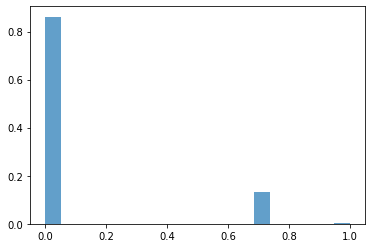

In [350]:
rs = []
for i in range(Hx.shape[0]):
    gen_qbts = qbts[np.where(Hx[i])[0]]
    rs.append(make_circle(gen_qbts)[2])
for i in range(Hz.shape[0]):
    gen_qbts = qbts[np.where(Hz[i])[0]]
    rs.append(make_circle(gen_qbts)[2])

scaled_rs = [(r - min(rs)) / (max(rs) - min(rs)) for r in rs]
bins = np.linspace(min(scaled_rs), max(scaled_rs), 20)
counts, _ = np.histogram(scaled_rs, bins=bins)
counts_weighter = counts.sum()

# print(code, np.percentile(scaled_rs, 70))
plt.hist(bins[:-1], bins=bins, weights=counts/counts_weighter, alpha=0.7)

In [353]:
hx1 = np.kron(H, np.eye(H.shape[1], dtype=bool))
hx2 = np.kron(np.eye(H.shape[0], dtype=bool), H.T)
Hx = np.hstack([hx1, hx2])

hz1 = np.kron(np.eye(H.shape[1], dtype=bool), H)
hz2 = np.kron(H.T, np.eye(H.shape[0], dtype=bool))
Hz = np.hstack([hz1, hz2])

n = Hx.shape[1]
m = 2*Hx.shape[0]
k = n-m
print(f"[[{n},{k},{rep_size*d}]]")

[[394,4,6]]


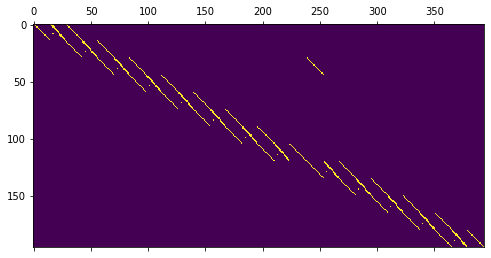

In [357]:
plt.matshow(Hx)

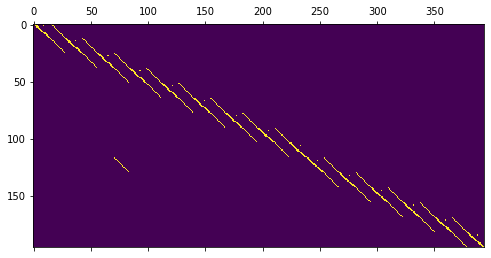

In [358]:
plt.matshow(Hz)